# Tutorial 26: Constraints on Numbers of Assets

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0256%,0.4057%,0.4035%,1.9693%,0.0180%,0.9305%,0.3678%,0.5784%,0.9483%,-1.1954%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1729%,0.2410%,1.3734%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1735%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5646%,0.3108%,-1.0155%,-0.7654%,-3.0048%,-0.9034%,-2.9144%
2016-01-07,-5.1389%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8855%,-4.6058%,-2.5394%,...,-2.2066%,-3.0310%,-1.0410%,-3.1557%,-1.6148%,-0.2699%,-2.2844%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1098%,-0.2241%,0.5707%,-1.6402%,-1.7642%,-0.1649%,...,-0.1539%,-1.1366%,-0.7308%,-0.1448%,0.0895%,-3.3839%,-0.1117%,-1.1387%,-0.9720%,-1.1254%
2016-01-11,-4.3383%,0.1693%,-1.6851%,-1.0215%,0.0914%,-1.1791%,0.5674%,0.5288%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1451%,1.2224%,1.4570%,0.5367%,-0.4607%,0.5799%,-1.9919%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,12.3499%,0.0000%,0.0000%,7.4896%,0.0000%,5.1443%,0.0000%,0.0000%,...,12.6870%,0.0000%,0.0000%,0.0000%,0.0000%,11.1966%,0.0000%,0.0000%,3.6753%,0.0000%


### 2.2 Plotting portfolio composition

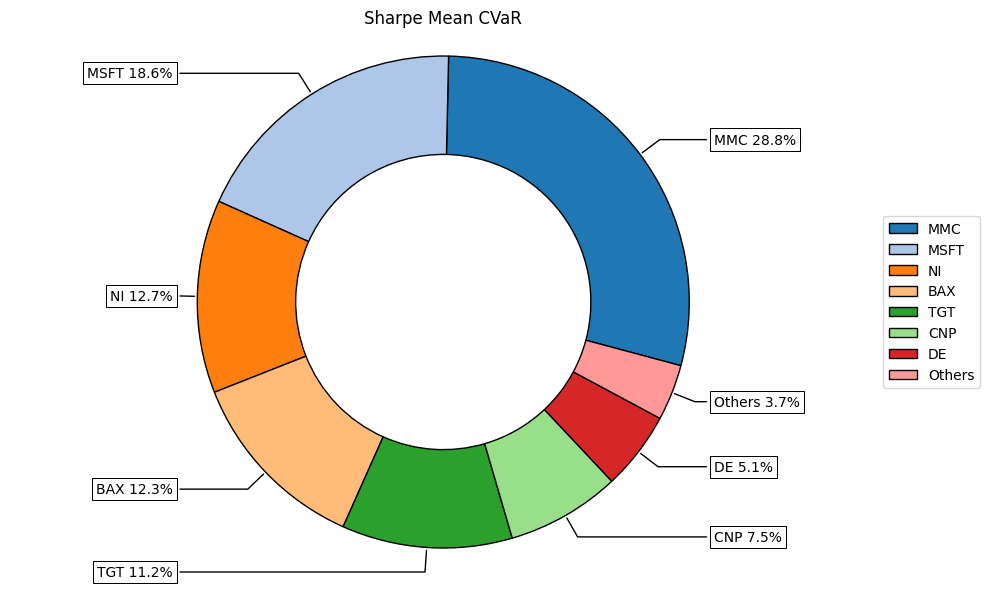

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Sharpe Mean CVaR',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)

In [5]:
# Number of assets in portfolio
n_assets = np.sum(np.where(np.round(w,4) > 0, 1, 0)).item()

# Number of effective assets in portfolio
nea = 1/np.sum(w ** 2).item()

print('Number of Assets:', n_assets)
print('Number of Effective Assets:', nea)

Number of Assets: 8
Number of Effective Assets: 5.838056749090513


### 2.3 Calculating the portfolio including a constraint on the maximum number of assets.

이러한 제약 조건은 최대 자산 수에 제한을 두는 데 도움이 됩니다. 이는 너무 많은 자산을 구매할 수 없는 소액 투자자에게 유용할 수 있습니다.

### 상세 설명:

1. **최대 자산 수 제약**:
   - **목적**: 포트폴리오에 포함될 수 있는 자산의 최대 개수를 제한합니다.
   - **이유**: 소액 투자자는 제한된 자본으로 인해 많은 자산을 구매하는 것이 어려울 수 있습니다. 따라서 포트폴리오 내 자산 수를 제한하면, 투자자들은 더 적은 수의 자산에 집중하여 효율적으로 투자할 수 있습니다.

2. **소액 투자자의 문제 해결**:
   - **문제점**: 소액 투자자는 자본이 제한되어 있기 때문에 많은 자산을 구매하는 데 어려움을 겪습니다. 또한, 자산 수가 많아질수록 거래 비용과 관리 복잡성도 증가합니다.
   - **해결책**: 최대 자산 수에 제한을 두면, 투자자는 중요한 자산에 집중할 수 있으며, 거래 비용과 관리 복잡성을 줄일 수 있습니다.

### 예시:

포트폴리오 최적화 문제에서 최대 자산 수에 대한 제약을 설정하는 방법을 간단한 코드 예시를 통해 설명하겠습니다.

```python
import numpy as np
import cvxpy as cp

# 예시 데이터
n_assets = 10  # 자산의 수
max_assets = 5  # 최대 자산 수 제한
returns = np.random.randn(n_assets)  # 가상의 자산 수익률
cov_matrix = np.random.randn(n_assets, n_assets)  # 가상의 공분산 행렬
cov_matrix = cov_matrix @ cov_matrix.T  # 공분산 행렬 만들기

# 변수 설정
w = cp.Variable(n_assets)  # 포트폴리오 가중치
z = cp.Variable(n_assets, boolean=True)  # 바이너리 변수: 자산 선택 여부

# 목적 함수: 수익률 최대화
objective = cp.Maximize(returns @ w)

# 제약 조건
constraints = [
    cp.sum(w) == 1,  # 가중치 합은 1
    w >= 0,  # 가중치는 0 이상
    w <= z,  # z가 1일 때만 w가 0보다 클 수 있음
    cp.sum(z) <= max_assets  # 최대 자산 수 제한
]

# 최적화 문제 정의 및 해결
prob = cp.Problem(objective, constraints)
prob.solve()

# 결과 출력
print("Optimal weights:", w.value)
print("Selected assets:", np.where(z.value > 0.5)[0])
```

이 예시 코드는 최대 자산 수를 제한하여 포트폴리오 최적화를 수행하는 방법을 보여줍니다. `z`는 각 자산이 포트폴리오에 포함될지 여부를 나타내는 바이너리 변수입니다. `w`는 포트폴리오 가중치를 나타냅니다. 제약 조건 중 `cp.sum(z) <= max_assets`는 최대 자산 수를 제한합니다.

이와 같은 제약 조건을 추가함으로써 소액 투자자는 제한된 자산 내에서 효율적으로 포트폴리오를 구성할 수 있습니다.

In [6]:
# First we need to set a solver that support Mixed Integer Programming
port.solvers = ['MOSEK']

# Then we need to set the cardinality constraint (maximum number of assets)
port.card = 5

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,14.6525%,0.0000%,0.0000%,25.2271%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,14.6288%,0.0000%,0.0000%,0.0000%,0.0000%


### 2.4 Plotting portfolio composition

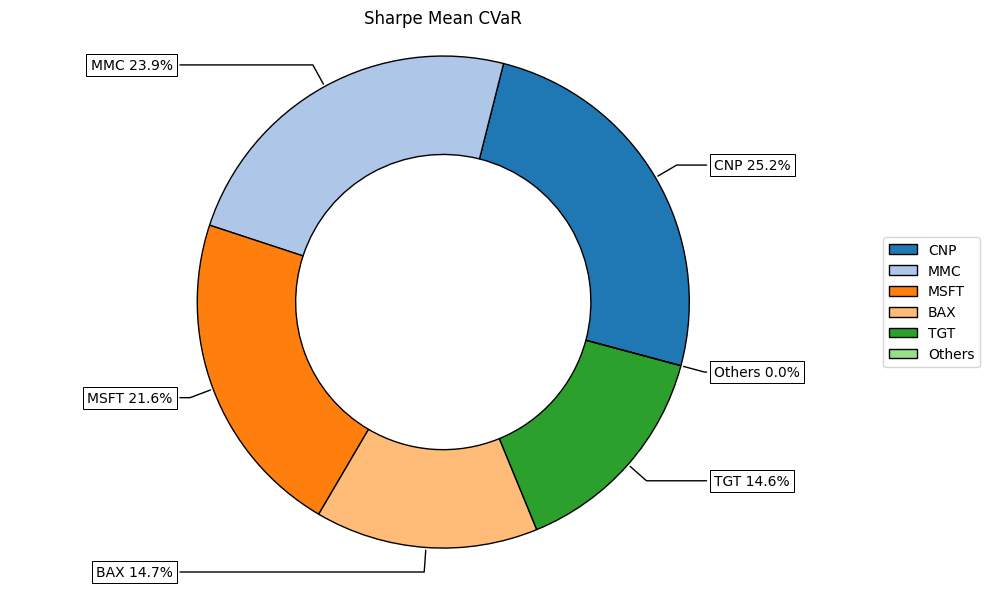

In [7]:
ax = rp.plot_pie(w=w,
                 title='Sharpe Mean CVaR',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)

In [8]:
# Number of assets in portfolio
n_assets = np.sum(np.where(np.round(w,4) > 0, 1, 0)).item()

# Number of effective assets in portfolio
nea = 1/np.sum(w ** 2).item()

print('Number of Assets:', n_assets)
print('Number of Effective Assets:', nea)

Number of Assets: 5
Number of Effective Assets: 4.756392353712353


### 2.5 Calculating the portfolio including a constraint on the minimum number of effective assets.

In [9]:
# First we need to delete the cardinality constraint
port.card = None 

# Then we need to set the constraint on the minimum number of effective assets
port.nea = 12

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,5.9946%,10.2051%,0.0000%,3.2055%,8.9363%,0.5313%,5.6819%,0.0000%,0.0000%,...,10.5071%,1.0959%,0.8459%,0.0000%,2.5692%,10.5068%,5.1072%,0.0000%,7.8715%,0.0000%


### 2.6 Plotting portfolio composition

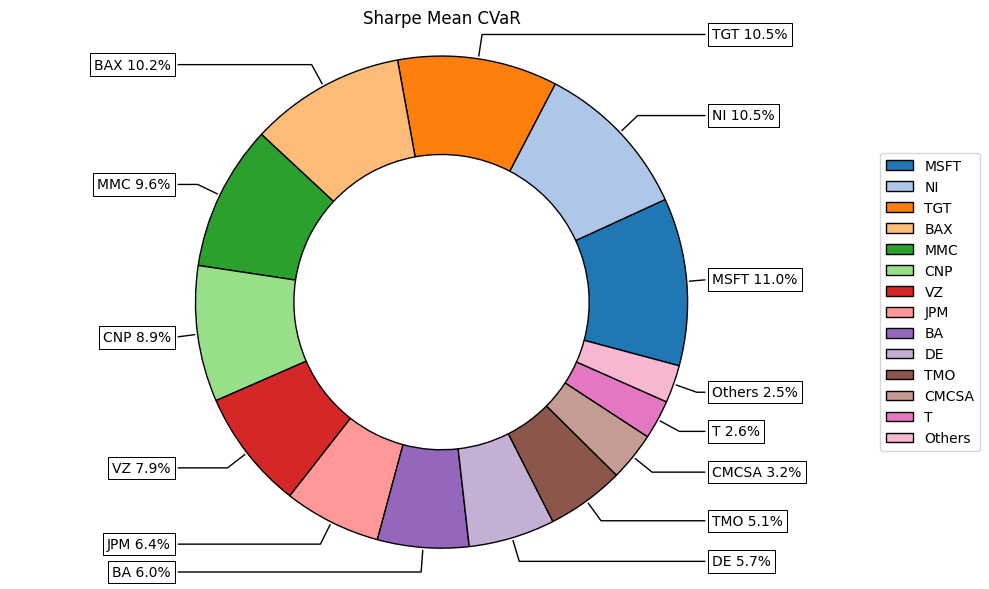

In [10]:
ax = rp.plot_pie(w=w,
                 title='Sharpe Mean CVaR',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

In [11]:
# Number of assets in portfolio
n_assets = np.sum(np.where(np.round(w,4) > 0, 1, 0)).item()

# Number of effective assets in portfolio
nea = 1/np.sum(w ** 2).item()

print('Number of Assets:', n_assets)
print('Number of Effective Assets:', nea)

Number of Assets: 16
Number of Effective Assets: 12.00000000287376
